<a href="https://colab.research.google.com/gist/arkhycat/86e18d5af4f8d0ed66b34eb2de00cd56/mnist_disentangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Loading the data

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

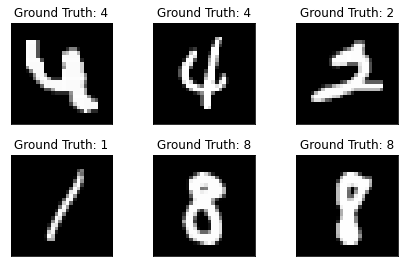

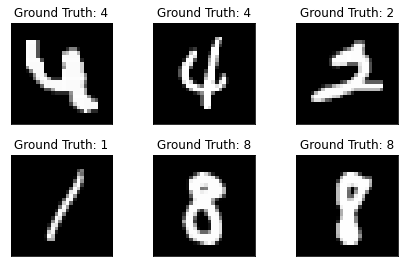

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Building the network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.last_layer = F.relu(self.fc1(x))
        x = F.dropout(self.last_layer, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
merged = []
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

  with torch.no_grad():
    print("!!!!!")
    output = network(example_data)
    last_layer = network.last_layer
    merged.append(np.hstack((last_layer, output.data)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.077739
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.820479
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.591998
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.496418
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.372594
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.608163
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.522564
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.559760

Test set: Avg. loss: 0.1933, Accuracy: 9436/10000 (94%)

!!!!!
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.389359
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.420494
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.520013
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.300040
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.571929
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.231038
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.342739
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


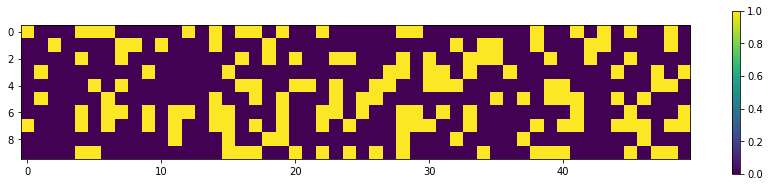

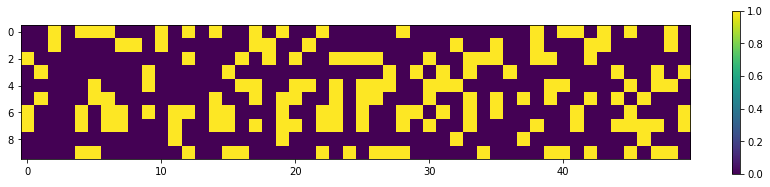

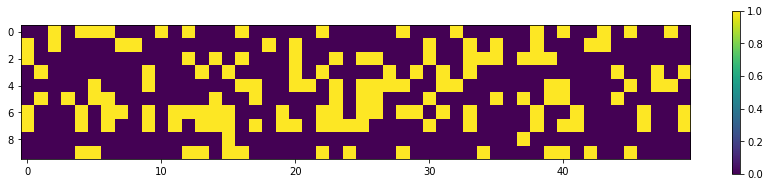

In [ ]:
for m in merged:
  plt.figure(figsize=(15,3))
  plt.imshow(np.abs(np.corrcoef(np.transpose(m)))[-10:, :-10]>0.4)
  plt.colorbar()

#Inspecting the results


In [ ]:
with torch.no_grad():
  output = network(example_data)
  last_layer = network.last_layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


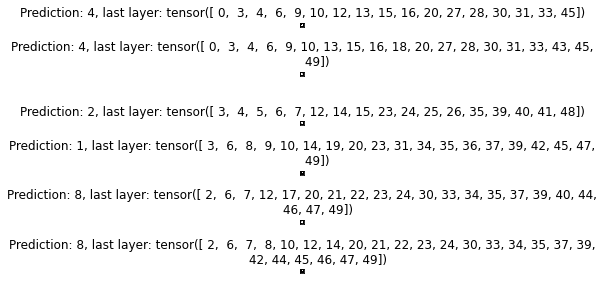

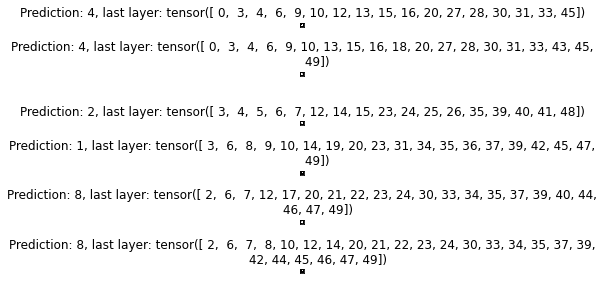

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(6,1,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}, last layer: {}".format((
    output.data.max(1, keepdim=True)[1][i].item()), torch.nonzero(last_layer[i]).flatten()))
  plt.xticks([])
  plt.yticks([])
fig

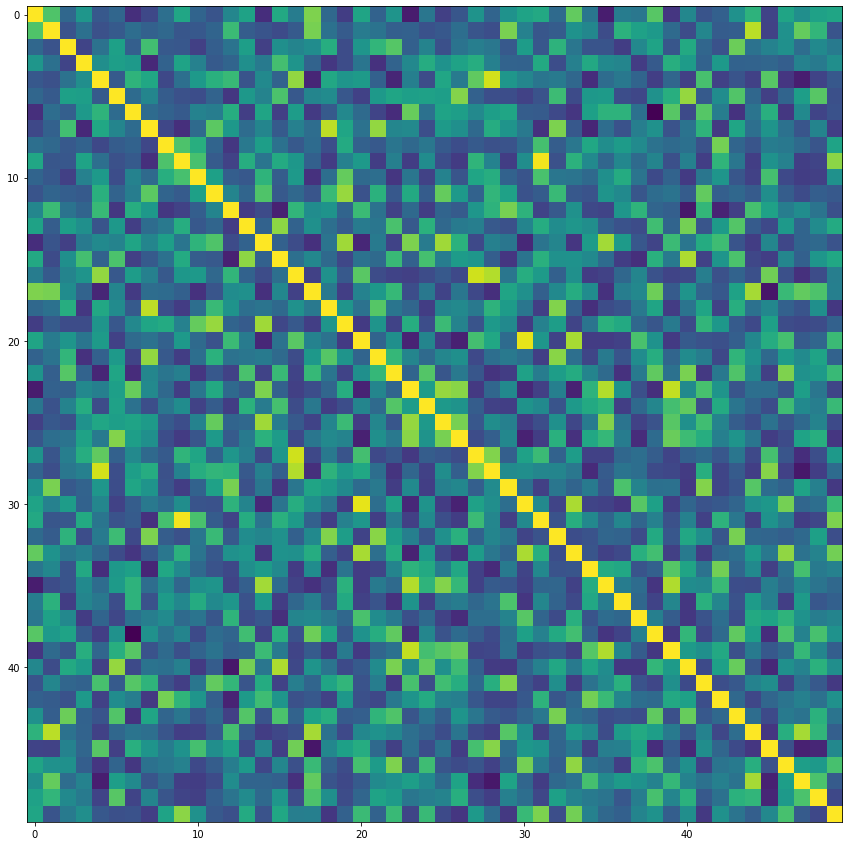

In [ ]:
import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(np.corrcoef(np.transpose(last_layer)))


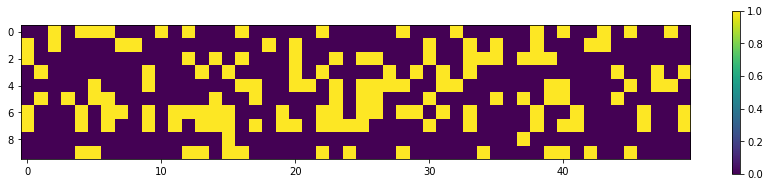

In [ ]:
merged = np.hstack((last_layer, output.data))

plt.figure(figsize=(15,3))
plt.imshow(np.abs(np.corrcoef(np.transpose(merged)))[-10:, :-10]>0.4)
plt.colorbar()

In [ ]:
merged = np.hstack((last_layer, output.data))
corrm = np.corrcoef(np.transpose(merged))[-10:, :-10]
act = [[] for i in range(10)]
for num, neu in zip(*np.where(np.abs(corrm)>0.5)):
  act[num].append(neu)
for i in range(10):
  print(i, len(act[i]))
act

0 5
1 2
2 7
3 5
4 8
5 9
6 9
7 12
8 0
9 7


[[4, 6, 28, 43, 45],
 [8, 38],
 [0, 20, 23, 30, 33, 35, 39],
 [9, 15, 31, 47, 49],
 [16, 21, 23, 26, 27, 45, 47, 48],
 [1, 14, 23, 25, 26, 35, 37, 39, 44],
 [4, 6, 11, 14, 23, 25, 29, 41, 49],
 [0, 11, 14, 17, 19, 22, 30, 33, 38, 41, 46, 49],
 [],
 [4, 12, 16, 24, 28, 34, 40]]

In [ ]:
class NetWOOut(nn.Module):
  def __init__(self, other):
      super(Net, self).__init__()
      self.net = other

  def forward(self, x):
      out = self.net(x)
      return last_layer

In [ ]:
!pip install captum

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
dl = DeepLift(net)
input = torch.randn(2, 3, 32, 32, requires_grad=True)
attribution = dl.attribute(input, target=3)